In [1]:
import jax
# #jax.config.update('jax_platform_name', 'cpu')
from jax import jit,device_put
import numpy as np
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

In [2]:
from emlp.reps import T
from emlp.groups import *

In [3]:
def krylov_constraint_solve_upto_r(C,r,tol=1e-5,lr=1e-2):#,W0=None):
    """ Iterative routine to compute the solution basis to the constraint CQ=0 and QᵀQ=I
        up to the rank r, with given tolerance. Uses gradient descent (+ momentum) on the
        objective |CQ|^2, which provably converges at an exponential rate."""
    W = np.random.randn(C.shape[-1],r)/np.sqrt(C.shape[-1])# if W0 is None else W0
    W = device_put(W)
    opt_init,opt_update = optax.sgd(lr,.9)
    opt_state = opt_init(W)  # init stats

    def loss(W):
        return (jnp.absolute(C@W)**2).sum()/2 # added absolute for complex support

    loss_and_grad = jit(jax.value_and_grad(loss))
    lstart, _ = loss_and_grad(W)
    lossvals = []
    for i in range(20000):
        lossval, grad = loss_and_grad(W)
        lossvals.append(lossval)
        updates, opt_state = opt_update(grad, opt_state, W)
        W = optax.apply_updates(W, updates)
        # update progress bar
        if jnp.sqrt(lossval) <tol: # check convergence condition
            break # has converged
    U,S,VT = np.linalg.svd(np.array(W),full_matrices=False) 
    rank = (S>10*tol).sum()
    Q = device_put(U[:,:rank])
    return jnp.array(lossvals)

In [4]:
r=20
k=4
C=T(k,G=SO(2)).constraint_matrix()

In [5]:
import pandas as pd

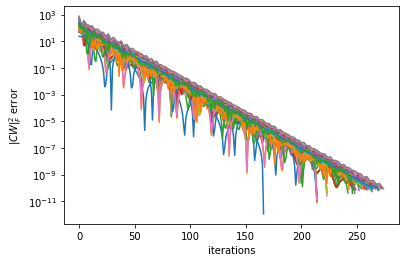

In [6]:
rows = []
groups = [SO(2),O(3),S(5),Z(6),D(4),SO13p(),Sp(2),SU(3),RubiksCube(),S(50)]
for G in groups:
    for k in range(1,7):
        r=50
        if r*G.d**k>2e8:continue
        rep = T(k//2,(k+1)//2,G=G)
        C=rep.constraint_matrix()
        if C.shape[0]*r*2>2e8: continue
        x = krylov_constraint_solve_upto_r(C,r)
        rows.append(pd.DataFrame({'iterations':np.arange(len(x)),r'$\|CW\|_F^2$ error':x,'Group':str(G),'Tensor Rank':k}))
        plt.plot(np.arange(len(x)),x,label=r"{}-$T_{}$".format(G,k))
df = pd.concat(rows)
#plt.title(r'Projected GD on $\|CW\|_F^2$')
plt.yscale('log')
plt.ylabel(r'$\|CW\|_F^2$ error')
plt.xlabel('iterations')
#plt.legend()
plt.show()

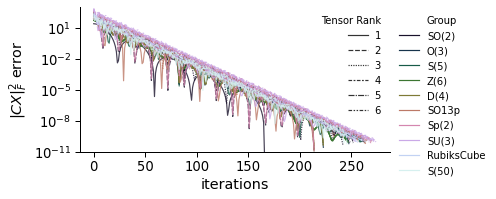

In [43]:
import seaborn as sns
#sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5) 
plot=sns.relplot(
    data=df,
    x='iterations', y=r'$\|CW\|_F^2$ error',
    hue="Group", style="Tensor Rank",palette= sns.color_palette("cubehelix",len(groups)),#sns.color_palette("rocket_r"),
    kind="line",alpha=.8,
    height=3, aspect=16/12,#legend=False,
)
plt.ylabel(r'$\|CX\|_F^2$ error')
plt.yscale('log')
#plt.xlim((-5,270))
plt.ylim((1e-11,1e3))
plot._legend.remove()


axes =plot.axes[0][0]
h,l = axes.get_legend_handles_labels()
l1 = axes.legend(h[:len(groups)+1],l[:len(groups)+1], loc='best',bbox_to_anchor=(1,1),framealpha=0,prop={'size': 10})

l2 = axes.legend(h[len(groups)+1:],l[len(groups)+1:], loc='best',framealpha=0,prop={'size': 10})
l2.handletextpad = 0
shift = max([t.get_window_extent().width for t in l2.get_texts()])
for t in l2.get_texts():
    t.set_ha('right') # ha is alias for horizontalalignment
    t.set_position((shift,0))
for l in l2.get_lines():
    l.set_xdata(np.array(l.get_xdata())+55)
axes.add_artist(l1)
plt.tight_layout()
plt.savefig(f'krylov_convergence.pdf', bbox_inches='tight')
plt.show()